In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePreprocessor.enabled=True]
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort c

# Import Data

In [14]:
train_df = pd.read_csv("trainhouseprices.csv")
train_df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [15]:
train_df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# 1. Provide appropriate descriptive statistics and visualizations to help understand the marginal distribution of the dependent variable.

In [16]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The 'SalePrice' description indicates right-skewness in the data, with the mean 'SalePrice' of $180,921 exceeding the median of $163,000.

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

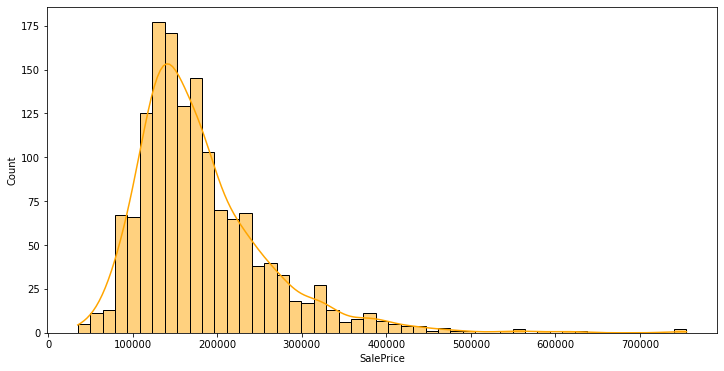

In [17]:
plt.figure(figsize = (12,6))
sns.histplot(data=train_df, kde=True, x='SalePrice', color="orange")

<AxesSubplot:xlabel='SalePrice'>

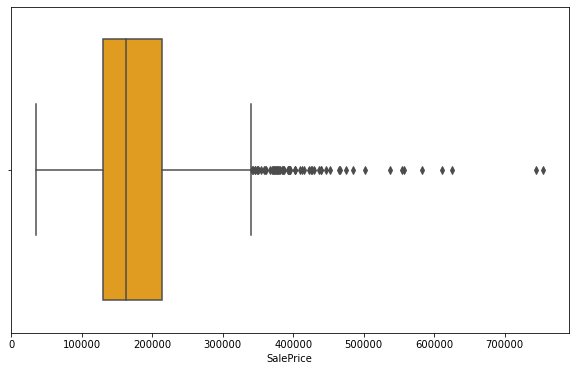

In [18]:
plt.figure(figsize = (10,6))
sns.boxplot(x=train_df["SalePrice"], color = "orange")

There appear to be a significant amount of outliers on the upper end of SalePrice, which is not unexpected with a right skew

# 2. Investigate missing data and outliers.

## 2.1 Missing Data

In [19]:
# Examine missing values in our data by column
mv_count = train_df.isnull().sum()
mv_percentage = (train_df.isnull().sum() * 100 / len(train_df)).round(2)
column_type = train_df.dtypes

mv_summary = pd.DataFrame({
    'Missing Count': null_count,
    'Percentage Missing': null_percentage,
    'Column Type': column_type
})

mv_summary_ascending = null_summary[null_count > 0].sort_values('Percentage Missing', ascending=False)

print("Summary of Missing Values:")
print(mv_summary_ascending)


Summary of Missing Values:
             Missing Count  Percentage Missing Column Type
LotFrontage            259               17.74     float64
GarageYrBlt             81                5.55     float64
MasVnrArea               8                0.55     float64
Electrical               1                0.07      object


The data dictionary indicates that a majority of the fields instead of signifying values, instead have NA assigned to them, which indicates "No Feature." Thus we should not fill missing values in columns with NA designation. Nor should we delete these columns as they are still pertinent information simply requiring transformation. 

In [20]:
na_columns = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']
train_df[na_columns] = train_df[na_columns].fillna('None')


In [21]:
null_count = train_df.isnull().sum()
null_percentage = (train_df.isnull().sum() * 100 / len(train_df)).round(2)
column_type = train_df.dtypes

null_summary = pd.DataFrame({
    'Missing Count': null_count,
    'Percentage Missing': null_percentage,
    'Column Type': column_type
})

null_summary_only_missing = null_summary[null_count > 0].sort_values('Percentage Missing', ascending=False)
print("Updated Summary of Missing Values:")
print(null_summary_only_missing)


Updated Summary of Missing Values:
             Missing Count  Percentage Missing Column Type
LotFrontage            259               17.74     float64
GarageYrBlt             81                5.55     float64
MasVnrArea               8                0.55     float64
Electrical               1                0.07      object


'LotFrontage', 'MasVnrArea', 'Electrical': data dictionary lists no reasons why these columns would have missing values. We will fill 'LotFrontage' based on 'Neighborhood' median, the rest lack significance (sub 1%missing values). 'GarageYrBlt': no data disctionary indication for null values, will fill based on house year built ('YearBuilt')

In [22]:
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

train_df['GarageYrBlt'].fillna(train_df['YearBuilt'], inplace=True)

In [23]:
#Determine if there are any duplicates
train_df.duplicated().sum()

0

## 2.2 Examining Outliers

We will only examine extreme outliers that coincide with 3*IQR above/below the first and third quartiles

In [24]:
num_df = train_df.select_dtypes(include=np.number)

Q1 = num_df.quantile(0.25)
Q3 = num_df.quantile(0.75)

IQR = Q3 - Q1

outlier1 = ((num_df < (Q1 - 3 * IQR)) | (num_df > (Q3 + 3 * IQR))).sum()
outlier2 = outlier1[outlier1 > 0]
outlier2.sort_values(ascending=False)


EnclosedPorch    208
BsmtFinSF2       167
ScreenPorch      116
BsmtHalfBath      82
KitchenAbvGr      68
MiscVal           52
LotArea           34
LowQualFinSF      26
MasVnrArea        25
3SsnPorch         24
OpenPorchSF       18
LotFrontage       13
SalePrice         12
PoolArea           7
TotalBsmtSF        5
GrLivArea          4
GarageArea         3
WoodDeckSF         3
1stFlrSF           3
TotRmsAbvGrd       1
BsmtFinSF1         1
OverallCond        1
BedroomAbvGr       1
dtype: int64

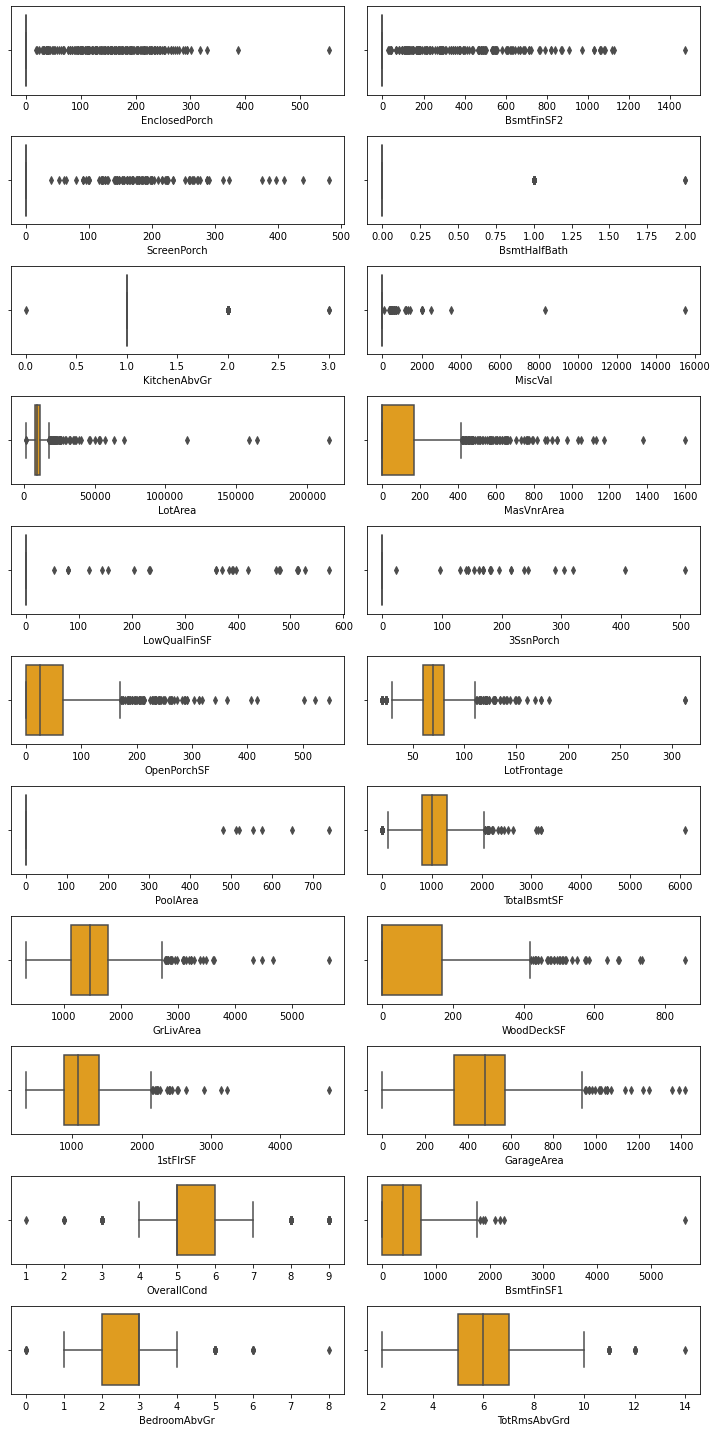

In [25]:
outlier3 = ['EnclosedPorch', 'BsmtFinSF2', 'ScreenPorch', 'BsmtHalfBath', 'KitchenAbvGr', 'MiscVal',
            'LotArea', 'MasVnrArea', 'LowQualFinSF', '3SsnPorch', 'OpenPorchSF', 'LotFrontage', 'PoolArea', 'TotalBsmtSF', 'GrLivArea', 'WoodDeckSF', '1stFlrSF', 
            'GarageArea', 'OverallCond', 'BsmtFinSF1', 'BedroomAbvGr', 'TotRmsAbvGrd']

fig, ax = plt.subplots(11, 2, figsize = (10, 20))

for var, subplot in zip(outlier3, ax.flatten()):
    sns.boxplot(x=train_df[var], ax = subplot, color = 'orange')
    
fig.tight_layout()


Based on the boxplots there is evidence for extreme outliers. However, it would be useful to examine these more closely relative to our dependent variable. And  outliers based on IQRx3 may still have strong correlation to our dependent variable.

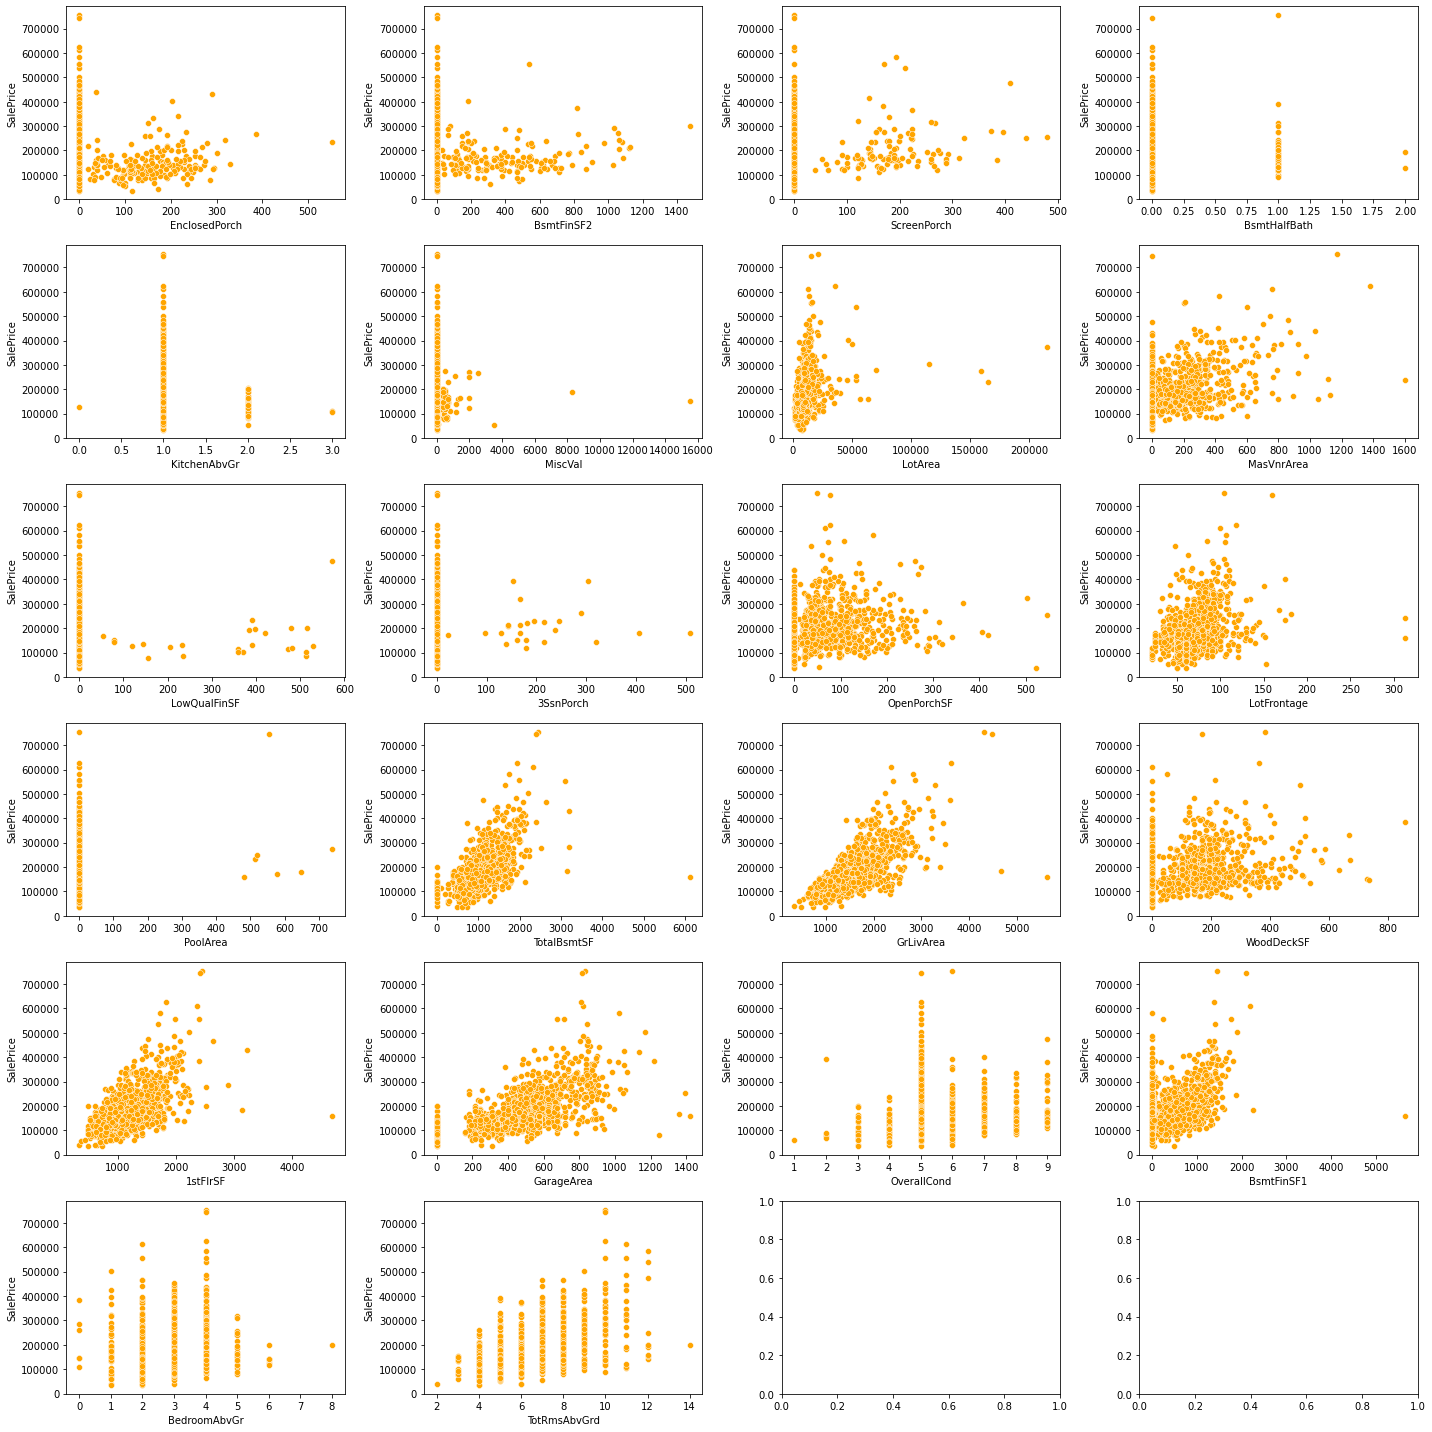

In [26]:
fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))

for i in range(6):
    for j in range(4):
        n = 4 * i + j
        
        if n < len(outlier3):
            sns.scatterplot(x=outlier3[n], y='SalePrice', data=train_df, ax=axs[i, j], color = 'orange')

fig.tight_layout()
plt.show()


After reviewing the plots, we can see that some outliers are more significant than others. A few such cases are: 
- 'LotFrontage'
- 'TotalBsmtSF' & 'BsmtFinSF1' (These are likely the same datapoints)
- 'GrLivArea' (only looking at the values corresponding to GrLivArea > 4000 & SalePrice < 200000)

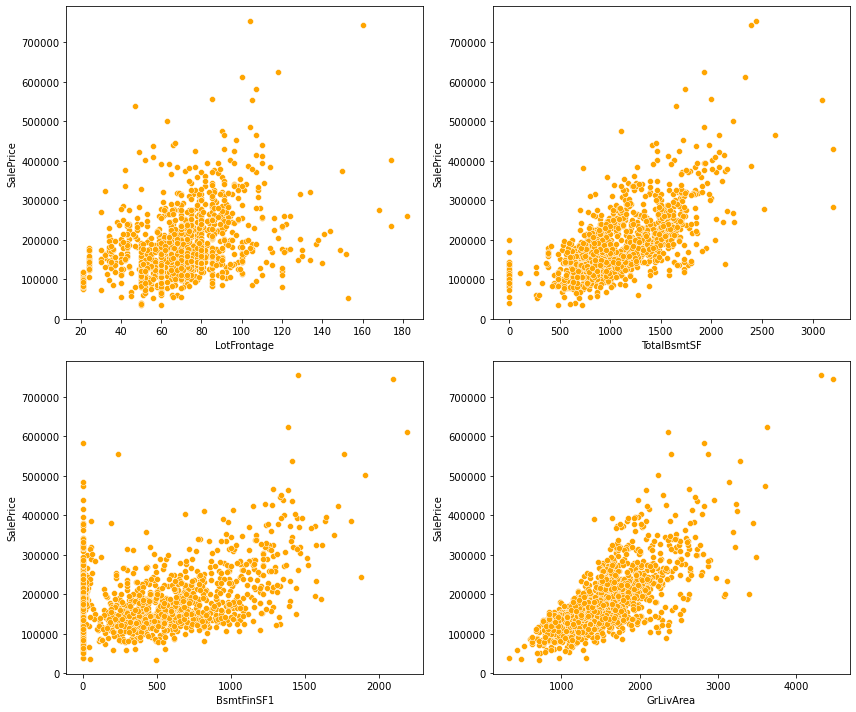

In [27]:
# Extreme outliers from the aforementioned variables will be dropped
train_df = train_df.drop(train_df[train_df['LotFrontage'] > 200].index)

train_df = train_df.drop(train_df[train_df['TotalBsmtSF'] > 4000].index)

train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 200000)].index)

# Plot the variables that were dropped
outlier4 = ['LotFrontage', 'TotalBsmtSF',  'BsmtFinSF1', 'GrLivArea']
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i in range(2):
    for j in range(2):
        n = 2 * i + j
        
        if n < len(outlier4):
            sns.scatterplot(x=outlier4[n], y='SalePrice', data=train_df, ax=axs[i, j], color = 'orange')

fig.tight_layout()
plt.show()

# 3. Investigate at least three potential predictors of the dependent variable and provide appropriate graphs / statistics to demonstrate the relationships.

I will check correlation using a corelation heatmap to view potential predictor variables with our dependent variable (SalePrice)

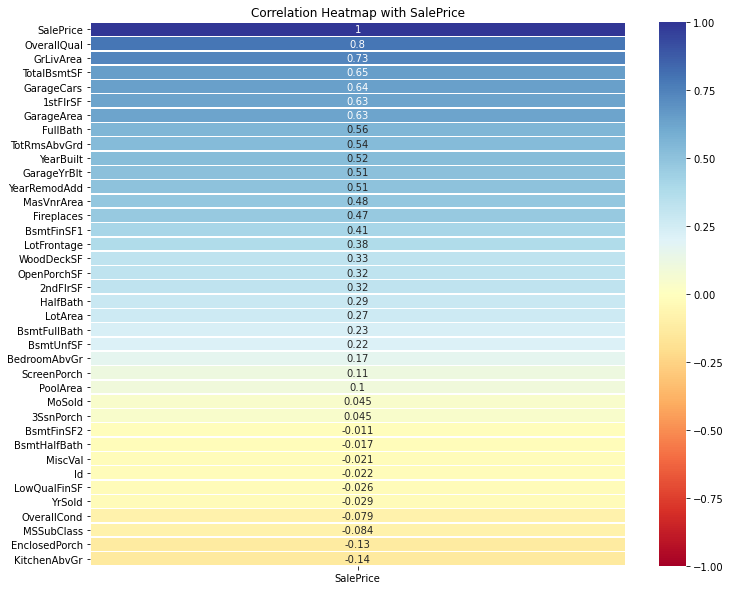

In [28]:
corr_matrix = train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['SalePrice']].sort_values(by='SalePrice', ascending=False),
            annot=True,
            cmap='RdYlBu',
            linewidths=0.5,
            vmin=-1, vmax=1,
            cbar=True)
plt.title('Correlation Heatmap with SalePrice')
plt.show()

In [29]:
corr_matrix = train_df.corr()
cor_target = abs(corr_matrix['SalePrice'])

relevant_features = cor_target[cor_target > 0.5]
relevant_features_sorted = relevant_features.sort_values(ascending=False)

print("Descending List of Highly Correlated Features:")
print(relevant_features_sorted)


Descending List of Highly Correlated Features:
SalePrice       1.000000
OverallQual     0.795707
GrLivArea       0.734842
TotalBsmtSF     0.652164
GarageCars      0.641033
1stFlrSF        0.631667
GarageArea      0.629268
FullBath        0.561982
TotRmsAbvGrd    0.537503
YearBuilt       0.523935
GarageYrBlt     0.509221
YearRemodAdd    0.507454
Name: SalePrice, dtype: float64


The 5 highest correlated variables are:

- OverallQual:   0.795707
- GrLivArea:     0.734842
- TotalBsmtSF:   0.652164
- GarageCars:    0.641033
- 1stFlrSF:      0.631667




### Predictor 1: OverallQual

'OverallQual' is a categorical variable that represents the overall quality of houses on a scale from 1 to 10. It is the top predictor of 'SalePrice', showing a strong positive qualitative correlation. In other words, as 'OverallQual' increases, 'SalePrice' tends to increase as well, indicating that the quality of a house is an important factor in determining its sale price.

Text(0.5, 1.0, 'Box Plot of SalePrice by OverallQual')

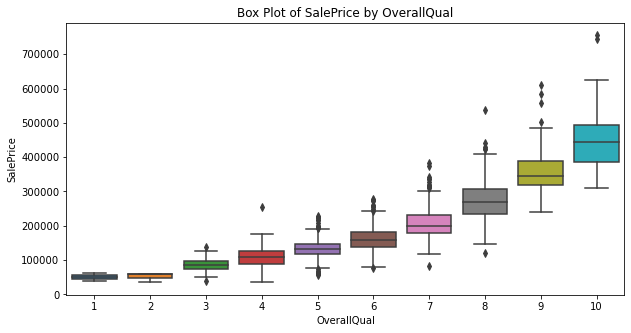

In [30]:
fig, axs = plt.subplots(figsize=(10, 5))
sns.boxplot(data=train_df, x='OverallQual', y='SalePrice', ax=axs)
axs.set_title('Box Plot of SalePrice by OverallQual')

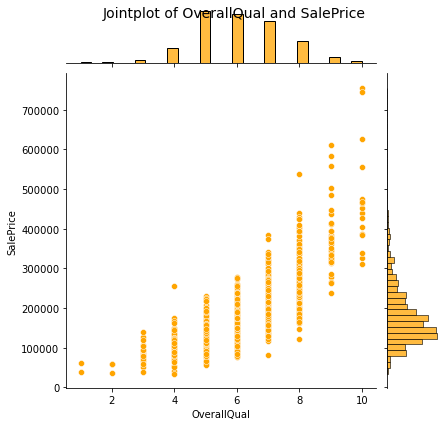

In [31]:
plot = sns.jointplot(x="OverallQual", y="SalePrice", data=train_df, color='orange')
plot.fig.suptitle("Jointplot of OverallQual and SalePrice", fontsize=14)
plt.show()

### Predictor 2: GrLivArea

'GrLivArea' exhibits a substantial positive correlation with 'SalePrice.' This variable represents the total livable square footage above ground in houses. The correlation indicates that as the livable square footage increases, the 'SalePrice' is expected to increase as well. In other words, a larger aboveground living area tends to be associated with a higher sale price for houses.

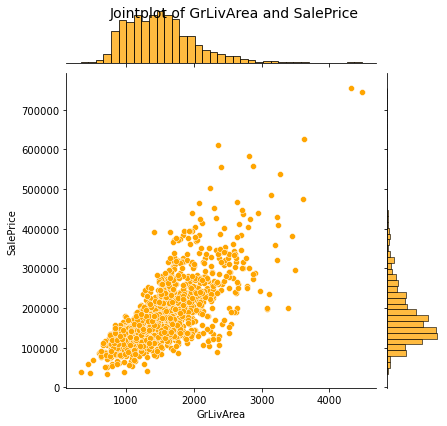

In [32]:
plot = sns.jointplot(x="GrLivArea", y="SalePrice", data=train_df, color='orange')
plot.fig.suptitle("Jointplot of GrLivArea and SalePrice", fontsize=14)
plt.show()

### Predictor 1 & 2

I want to focus on a specific comparison between two key variables, 'OverallQual' and 'GrLivArea,' concerning their relationship with the dependent variable, 'SalePrice.'

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

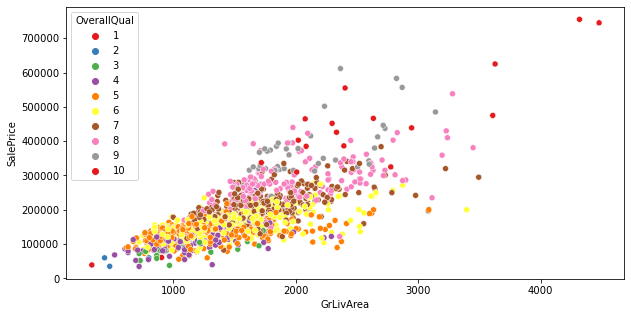

In [33]:
fig, axs = plt.subplots(figsize=(10, 5))
palette_name = 'Set1'  
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'], hue=train_df['OverallQual'], palette=palette_name, ax=axs)




In the presented plot, each rating of 'OverallQual' (ranging from 1 to 10) is visually distinguished by a different color. The plot reveals distinct tiers based on 'OverallQual,' spanning a wide range of 'GrLivArea' values (total living square footage above ground). When examining each color individually, corresponding to different 'OverallQual' values, most of them display positive slopes. These positive slopes are primarily attributed to increases in living square footage, which drive up 'SalePrice' within the same 'OverallQual' rating. This observation aligns with the known correlation between these two variables and 'SalePrice,' with the distinct color tiers indicating that 'OverallQual' has a stronger influence on 'SalePrice' compared to 'GrLivArea.'

## Catagorical Predictor

### Predictor 3: Neighborhood

Among the categorical variables in the dataset, 'Neighborhood' stands out as having a significant distribution across various categories. This suggests that there is a diverse range of neighborhoods represented in the data. Given the common understanding that neighborhoods often have a substantial impact on house prices, the objective is to investigate whether 'Neighborhood' serves as a predictor for 'SalePrice.' Specifically, the goal is to determine if there are meaningful differences in 'SalePrice' based on the different 'Neighborhood' categories. This analysis aims to assess the influence of neighborhood location on housing prices in the dataset.

In [34]:
neighbor_counts = train_df['Neighborhood'].value_counts()
print(neighbor_counts)

NAmes      224
CollgCr    150
OldTown    113
Edwards     98
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64


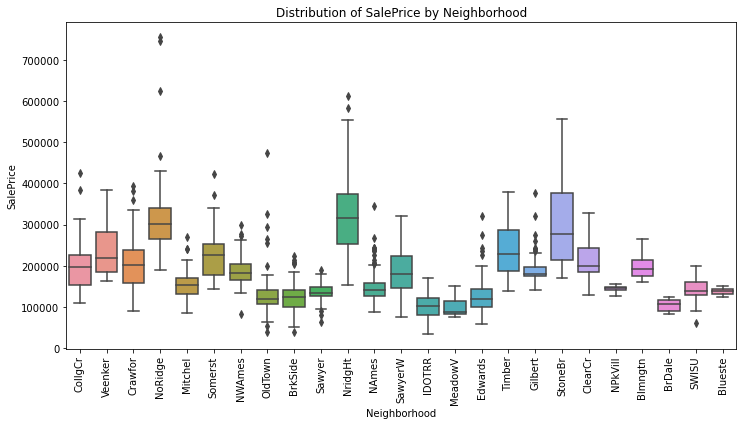

In [35]:
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=train_df, x='Neighborhood', y='SalePrice')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Distribution of SalePrice by Neighborhood')
plt.show()

In [36]:
train_df.groupby(['Neighborhood']).SalePrice.median().sort_values(ascending=False)

Neighborhood
NridgHt    315000
NoRidge    301500
StoneBr    278000
Timber     228475
Somerst    225500
Veenker    218000
Crawfor    200624
ClearCr    200250
CollgCr    197200
Blmngtn    191000
NWAmes     182900
Gilbert    181000
SawyerW    179900
Mitchel    153500
NPkVill    146000
NAmes      140000
SWISU      139500
Blueste    137500
Sawyer     135000
BrkSide    124300
Edwards    119500
OldTown    119000
BrDale     106000
IDOTRR     103000
MeadowV     88000
Name: SalePrice, dtype: int64

The analysis of 'SalePrice' across different neighborhoods reveals substantial variations in housing prices. The neighborhood labeled 'NridgHT' stands out with the highest median 'SalePrice' of $315,000, which is approximately three times greater than the neighborhood with the lowest median 'SalePrice' of $88,000, denoted as 'MeadowV.' Furthermore, it's noteworthy that even the lowest 'SalePrice' data point within the 'NridgHT' neighborhood exceeds the medians of several other neighborhoods. These observations underscore the significant impact of neighborhood location on housing prices.

# 4. Engage in feature creation by splitting, merging, or otherwise generating a new predictor.

In this section, a new predictive feature named 'TotalSF' is being created. It is inspired by my parents who increased our house's sale price by including the basement square footage to the house's total. 'TotalSF' represents the total square footage of a property and is calculated by summing the square footage of the basement ('TotalBsmtSF'), the first floor ('1stFlrSF'), and the second floor ('2ndFlrSF'). This new feature is expected to be a valuable predictor of 'SalePrice' by capturing the impact of total square footage on housing prices.

In [37]:
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
train_df['TotalSF'].describe()


count    1457.000000
mean     2557.083734
std       774.371429
min       334.000000
25%      2008.000000
50%      2473.000000
75%      3003.000000
max      6872.000000
Name: TotalSF, dtype: float64

In [38]:
train_df['GrLivArea'].describe()

count    1457.000000
mean     1510.082361
std       507.841835
min       334.000000
25%      1128.000000
50%      1459.000000
75%      1776.000000
max      4476.000000
Name: GrLivArea, dtype: float64

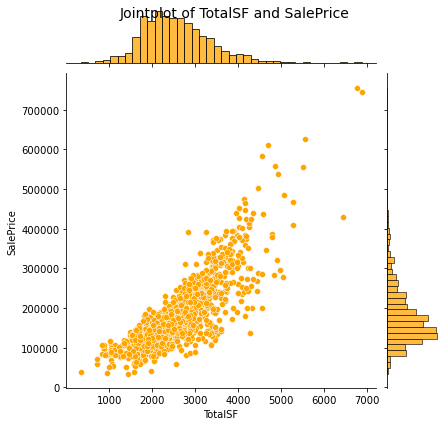

In [39]:
plot = sns.jointplot(x="TotalSF", y="SalePrice", data=train_df, color='orange')
plot.fig.suptitle("Jointplot of TotalSF and SalePrice", fontsize=14)
plt.show()

In [40]:
corr_matrix = train_df.corr()
cor_target = abs(corr_matrix['SalePrice'])

relevant_features = cor_target[cor_target > 0.5]
relevant_features_sorted = relevant_features.sort_values(ascending=False)

print("Updated Descending List of Highly Correlated Features:")
print(relevant_features_sorted)

Updated Descending List of Highly Correlated Features:
SalePrice       1.000000
TotalSF         0.832984
OverallQual     0.795707
GrLivArea       0.734842
TotalBsmtSF     0.652164
GarageCars      0.641033
1stFlrSF        0.631667
GarageArea      0.629268
FullBath        0.561982
TotRmsAbvGrd    0.537503
YearBuilt       0.523935
GarageYrBlt     0.509221
YearRemodAdd    0.507454
Name: SalePrice, dtype: float64


# 5. Using the dependent variable, perform both min-max and standard scaling in Python.

### Min-Max Scaling

In [41]:
mmscaler = MinMaxScaler()

train_df['SalePrice_mmscaled'] = mmscaler.fit_transform(train_df[['SalePrice']])

print(train_df['SalePrice_mmscaled'].describe())

count    1457.000000
mean        0.202737
std         0.110410
min         0.000000
25%         0.131926
50%         0.177892
75%         0.248715
max         1.000000
Name: SalePrice_mmscaled, dtype: float64


The correct transformation has been successfully performed, as evidenced by the scaled 'SalePrice' variable ('SalePrice_scaled') ranging from 0 (minimum) to 1 (maximum).

<AxesSubplot:xlabel='SalePrice_mmscaled', ylabel='Count'>

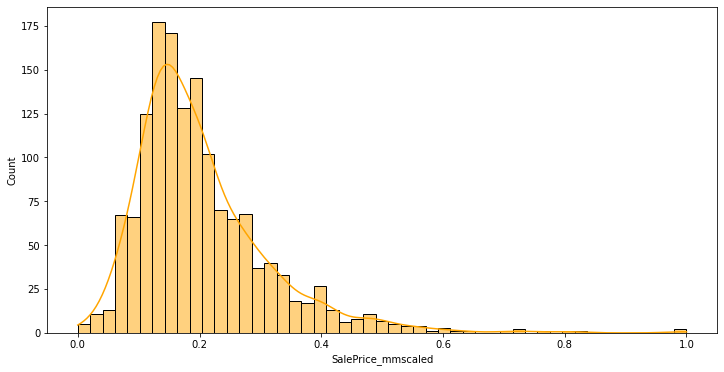

In [42]:
plt.figure(figsize = (12,6))
sns.histplot(data=train_df, kde=True, x='SalePrice_mmscaled', color="orange")

Examining Min-Max scaling on the two most correlated variables: 'OverallQual' and 'TotalSF'

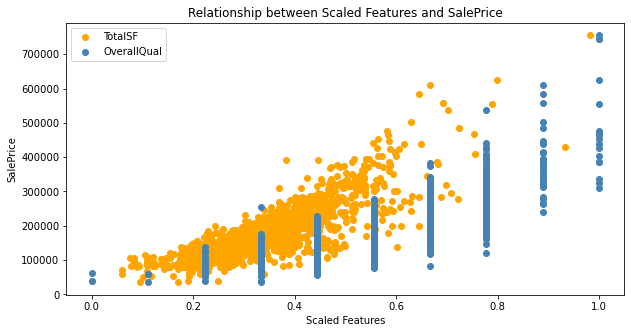

In [43]:
features = ['TotalSF', 'OverallQual']
features_df = train_df[features]

scaler = MinMaxScaler()
minmax_features = scaler.fit_transform(features_df)

sale_price = train_df["SalePrice"]
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(x=minmax_features[:, 0], y=sale_price, label='TotalSF', color='orange')
ax.scatter(x=minmax_features[:, 1], y=sale_price, label='OverallQual', color='steelblue')

ax.set_xlabel('Scaled Features')
ax.set_ylabel('SalePrice')
ax.legend()

ax.set_title('Relationship between Scaled Features and SalePrice')
plt.show()

Test apply logarithmic transformation for a better fit

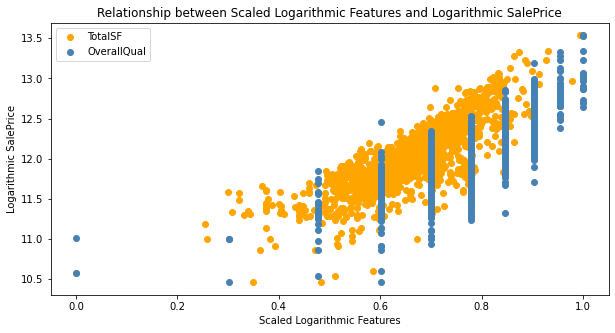

In [44]:
features = ['TotalSF', 'OverallQual']
features_df = train_df[features]

features_df_log = np.log(features_df)
sale_price_log = np.log(train_df["SalePrice"])

scaler = MinMaxScaler()
minmax_features = scaler.fit_transform(features_df_log)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x=minmax_features[:, 0], y=sale_price_log, label='TotalSF', color='orange')
ax.scatter(x=minmax_features[:, 1], y=sale_price_log, label='OverallQual', color='steelblue')

ax.set_xlabel('Scaled Logarithmic Features')
ax.set_ylabel('Logarithmic SalePrice')
ax.legend()

ax.set_title('Relationship between Scaled Logarithmic Features and Logarithmic SalePrice')
plt.show()

There is visual benefit to logarithmic transformations when min-max scaling. The distributions are much more in line with each other and comparable after transformation.

### Standard Scaling

In [45]:
stscaler = StandardScaler()

train_df['SalePrice_stscaled'] = stscaler.fit_transform(train_df[['SalePrice']])
print(train_df['SalePrice_stscaled'].describe())

count    1.457000e+03
mean    -1.493886e-16
std      1.000343e+00
min     -1.836851e+00
25%     -6.415662e-01
50%     -2.251037e-01
75%      4.165757e-01
max      7.223410e+00
Name: SalePrice_stscaled, dtype: float64


With the mean of the newly standardized 'SalePrice' variable approximately equal to 0 and its standard deviation approximately equal to 1, we can be confident that the transformation was executed correctly and successfully.

<AxesSubplot:xlabel='SalePrice_stscaled', ylabel='Count'>

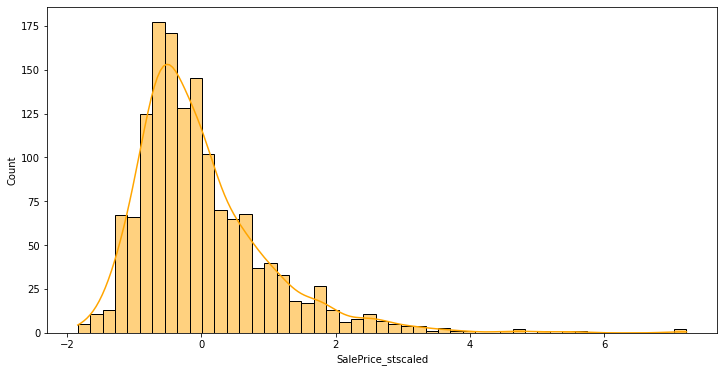

In [46]:
plt.figure(figsize = (12,6))
sns.histplot(data=train_df, kde=True, x='SalePrice_stscaled', color="orange")

Examining Standard scaling on the two most correlated variables: 'OverallQual' and 'TotalSF'

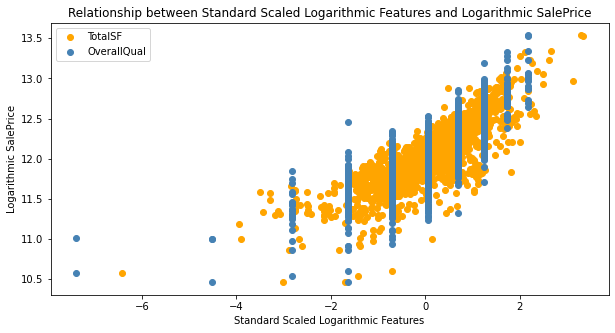

In [47]:
features = ['TotalSF', 'OverallQual']
features_df = train_df[features]

features_df_log = np.log(features_df)
sale_price_log = np.log(train_df["SalePrice"])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df_log)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x=scaled_features[:, 0], y=sale_price_log, label='TotalSF', color='orange')
ax.scatter(x=scaled_features[:, 1], y=sale_price_log, label='OverallQual', color='steelblue')

ax.set_xlabel('Standard Scaled Logarithmic Features')
ax.set_ylabel('Logarithmic SalePrice')
ax.legend()

ax.set_title('Relationship between Standard Scaled Logarithmic Features and Logarithmic SalePrice')
plt.show()


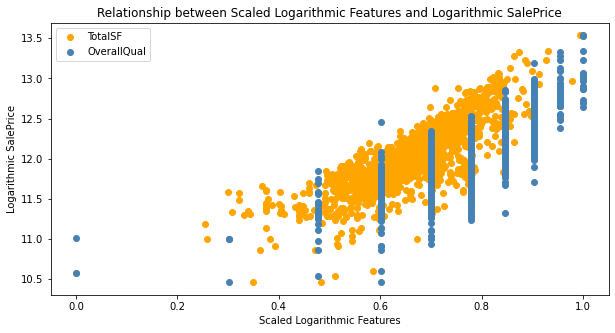

In [48]:
features = ['TotalSF', 'OverallQual']
features_df = train_df[features]

features_df_log = np.log(features_df)
sale_price_log = np.log(train_df["SalePrice"])

scaler = MinMaxScaler()
minmax_features = scaler.fit_transform(features_df_log)

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x=minmax_features[:, 0], y=sale_price_log, label='TotalSF', color='orange')
ax.scatter(x=minmax_features[:, 1], y=sale_price_log, label='OverallQual', color='steelblue')

ax.set_xlabel('Scaled Logarithmic Features')
ax.set_ylabel('Logarithmic SalePrice')
ax.legend()

ax.set_title('Relationship between Scaled Logarithmic Features and Logarithmic SalePrice')
plt.show()


In the standard scaling, there appears better alignment between variables in the non-logarithmic transpormation plot than after logarithmic transformation. There is less of an effect on standard scaling than there is on min-max scaling.

# Module 2 Assignment 1: Kaggle Competition
#### Conduct your analysis using a cross-validation design



In [76]:
test_df = pd.read_csv('testhp.csv')

test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Dichotomous Variable: Central Air & Street

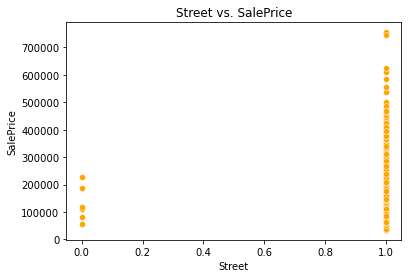

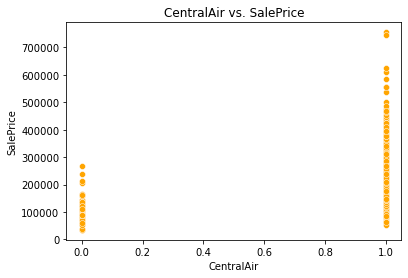

In [143]:
sns.scatterplot(x=train_df['Street'], y=train_df['SalePrice'], color='orange')
plt.title('Street vs. SalePrice')
plt.show()

sns.scatterplot(x=train_df['CentralAir'], y=train_df['SalePrice'], color='orange')
plt.title('CentralAir vs. SalePrice')
plt.show()


In [116]:
X = train_df[['Street']]  
y = train_df['SalePrice']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Accuracy measure
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.017123287671232876


With this accuracy score, we can see that 'Street' is a poor predictor of 'SalePrice'

In [70]:
# Transform the data
label_encoder = LabelEncoder()
train_df['Street'] = label_encoder.fit_transform(train_df['Street'])
train_df['CentralAir'] = label_encoder.fit_transform(train_df['CentralAir'])

X = train_df[['Street', 'CentralAir']]
y = train_df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.02


This accuracy score is slightly higher and weights both variables 'Street' and 'CentralAir' as predictors of 'SalePrice.' However, the accuracy score is still way too insufficient to be accurate.

## First regression model: 'TotalSF' predictor

In [120]:
X = train_df[['TotalSF']].copy()
y = train_df['SalePrice'].copy()

# Missing values
X['TotalSF'].fillna(X['TotalSF'].median(), inplace=True)  

# Log function
X['TotalSF'] = np.log1p(X['TotalSF'])
y = np.log1p(y)

model = LinearRegression()

# K-Folds (K=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard Deviation of RMSE: {np.std(rmse_scores)}')


Average RMSE: 0.23049691619853352
Standard Deviation of RMSE: 0.004446446588953352


In [121]:
model.fit(X, y)

LinearRegression()

In [113]:
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']
# Test missing values
test_df['TotalSF'].fillna(test_df['TotalSF'].median(), inplace=True)
test_df['TotalSF'] = test_df['TotalSF'].astype(float)
# Test log transfomration
test_df['TotalSF'] = np.log1p(test_df['TotalSF'])

x_kaggle_test = test_df[['TotalSF']].copy()

predictions_kaggle = model.predict(x_kaggle_test)

submission_df = pd.DataFrame({
    'Id': test_df['Id'],        
    'SalePrice': np.expm1(predictions_kaggle)  
})

submission_df.to_csv('kaggle_submission_totalsf_transform.csv', index=False)

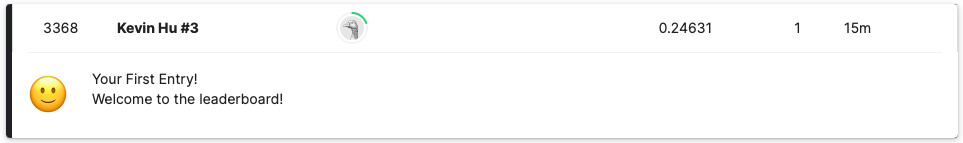

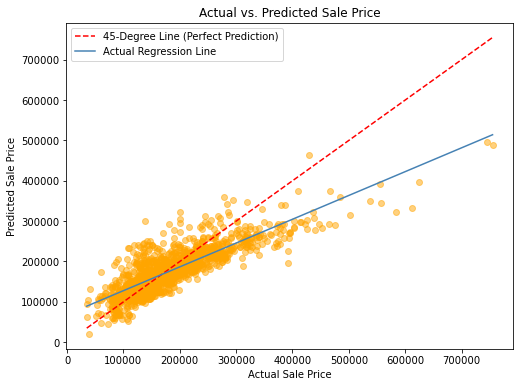

In [124]:
# To Sale Prices
actual_sale_price = np.expm1(y)

# To Predicted Sales Prices
predicted_sale_price = np.expm1(model.predict(X))

# Scatterplot 
plt.figure(figsize=(8, 6))
plt.scatter(actual_sale_price, predicted_sale_price, alpha=0.5, color = 'orange')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs. Predicted Sale Price')

# 45 degree regression line
x = np.linspace(min(actual_sale_price), max(actual_sale_price), 100)
y_45_deg = x  # Perfect prediction line

# Actual regression line
regression_model = LinearRegression()
regression_model.fit(actual_sale_price.values.reshape(-1, 1), predicted_sale_price)
y_actual_regression = regression_model.predict(x.reshape(-1, 1))

plt.plot(x, y_45_deg, color='red', linestyle='--', label='45-Degree Line (Perfect Prediction)')
plt.plot(x, y_actual_regression, color='steelblue', linestyle='-', label='Actual Regression Line')

plt.legend()
plt.show()


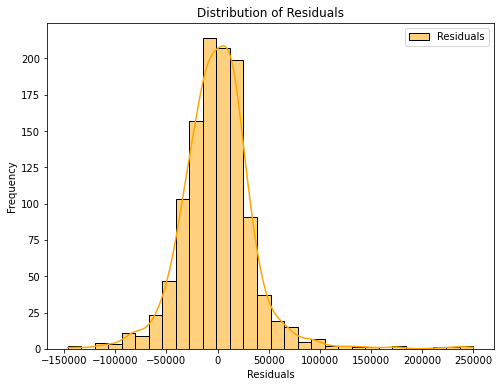

In [126]:
# Distribution of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='orange', label='Residuals', edgecolor='k')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.legend()
plt.show()

### Examining 'TotalSF' untransformed 

I had initially started with the transformed 'TotalSF' variable because from the previous EDA, it had the best fit when looking at the plots in the scaling section. Now examining an untransformed version of the same variable to compare with. 

In [129]:
X = train_df[['TotalSF']].copy()
y = train_df['SalePrice'].copy()

# Account for missing values
X['TotalSF'].fillna(X['TotalSF'].median(), inplace=True)  
y.fillna(y.median(), inplace=True)  

model = LinearRegression()

# K-folds (K=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard Deviation of RMSE: {np.std(rmse_scores)}')

# Model training
model.fit(X, y)

# Creat 'TotalSF' and clean test data
test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']
test_df['TotalSF'].fillna(test_df['TotalSF'].median(), inplace=True)
test_df['TotalSF'] = test_df['TotalSF'].astype(float)

x_kaggle_test = test_df[['TotalSF']].copy()
predictions_kaggle = model.predict(x_kaggle_test)

submission_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions_kaggle
})

submission_df.to_csv('kaggle_submission_totalsf.csv', index=False)


Average RMSE: 43991.014073582846
Standard Deviation of RMSE: 2615.667327691993


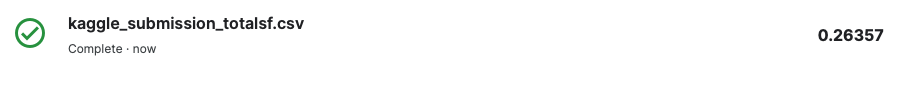

## Indicator Component

In [91]:
# RoofStyle --> dummy variables
roof_dummies_train = pd.get_dummies(train_df['RoofStyle'], prefix='RoofStyle')
train_df = pd.concat([train_df, roof_dummies_train], axis=1)

X = train_df.drop(columns=['RoofStyle', 'RoofStyle_Flat']).filter(like='RoofStyle_')
y = train_df['SalePrice'].copy()

# Make 'SalePrice' normally distributed
y = np.log1p(y)

model = LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard Deviation of RMSE: {np.std(rmse_scores)}')

model.fit(X, y)

# Test RoofStyle --> Dummy var
roof_dummies_test = pd.get_dummies(test_df['RoofStyle'], prefix='RoofStyle')
test_df = pd.concat([test_df, roof_dummies_test], axis=1)

x_kaggle_test = test_df.drop(columns=['RoofStyle', 'RoofStyle_Flat']).filter(like='RoofStyle_')

predictions_kaggle = model.predict(x_kaggle_test)

submission_df = pd.DataFrame({
    'Id': test_df['Id'],        
    'SalePrice': np.expm1(predictions_kaggle)  
})

submission_df.to_csv('kaggle_submission_roofstyle.csv', index=False)

Average RMSE: 0.3920509532710278
Standard Deviation of RMSE: 0.02013025726087614


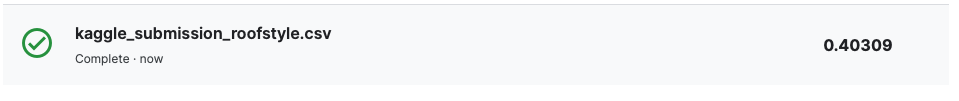

# Piece Wise Component

I chose to evaluate GrLivArea at a random interval within the main cluster of data points. I'm hopeful that both will be well correlated however, we will see the differences between data that is close together and data that is more spread out based on the breakpoint at 2000.

In [130]:
X = train_df[['GrLivArea']].copy()
y = train_df['SalePrice']

breakpoint = 2000

X['Below_Breakpoint'] = np.where(X['GrLivArea'] <= breakpoint, X['GrLivArea'], 0)
X['Above_Breakpoint'] = np.where(X['GrLivArea'] > breakpoint, X['GrLivArea'] - breakpoint, 0)

model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard Deviation of RMSE: {np.std(rmse_scores)}')

model.fit(X, y)

test_X = test_df[['GrLivArea']].copy()
test_X['Below_Breakpoint'] = np.where(test_X['GrLivArea'] <= breakpoint, test_X['GrLivArea'], 0)
test_X['Above_Breakpoint'] = np.where(test_X['GrLivArea'] > breakpoint, test_X['GrLivArea'] - breakpoint, 0)

predictions = model.predict(test_X)

submission_df = pd.DataFrame({
    'Id': test_df['Id'],        
    'SalePrice': predictions
})
submission_df.to_csv('piecewise_regression_submission.csv', index=False)



Average RMSE: 53726.50348304272
Standard Deviation of RMSE: 4370.18428339887


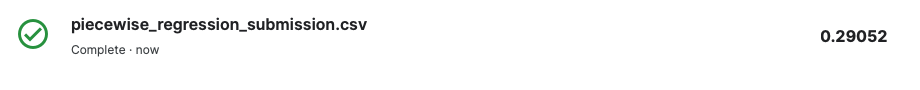

In [131]:
# Clsoer examine the differences in correlation above and below the breakpoint = 2000
train_df['GrLivArea_Below_Breakpoint'] = np.where(train_df['GrLivArea'] <= breakpoint, train_df['GrLivArea'], 0)
train_df['GrLivArea_Above_Breakpoint'] = np.where(train_df['GrLivArea'] > breakpoint, train_df['GrLivArea'] - breakpoint, 0)

correlations = train_df[['GrLivArea_Below_Breakpoint', 'GrLivArea_Above_Breakpoint', 'SalePrice']].corr()

print(correlations['SalePrice'])

GrLivArea_Below_Breakpoint   -0.201547
GrLivArea_Above_Breakpoint    0.560830
SalePrice                     1.000000
Name: SalePrice, dtype: float64


A positive correlation coefficient for 'GrLivArea_Above_Breakpoint' indicates a positive linear relationship between the two variables. As the predictor variable increases, the predicted variable also increases. A negative coefficient for 'GrLivArea_Below_Breakpoint' demonstrates similar movement however, in the opposite direction. Where a decrease in the predictor variable values would predict a decrease in the predicted value, 'SalePrice.' Positive correlations indicate that larger living areas (above the breakpoint) are positively related to sale prices, while smaller living areas (below the breakpoint) are negatively related to sale prices. Due to 'GrLivArea_Above_Breakpoint' having an absolute value of their correlation coefficient closer to 1, 'GrLivArea' is a stronger predictor of 'SalePrice' above the breakpoint of 2000.


## Polynomial Feature: GrLivArea
I would like to compare how the predictive model changes between using GrLivArea with no transformations (used in piecewise) and with a polynomial change via a second degree. 

In [95]:
X = train_df[['GrLivArea']].copy()
y = train_df['SalePrice']

# 2nd degree polynomial feature
poly = PolynomialFeatures(degree=2, include_bias=False)  
X_poly = poly.fit_transform(X)

model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = np.sqrt(-cross_val_score(model, X_poly, y, scoring='neg_mean_squared_error', cv=kf))
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard Deviation of RMSE: {np.std(rmse_scores)}')

model.fit(X_poly, y)

test_X = test_df[['GrLivArea']].copy()
test_X_poly = poly.transform(test_X)

predictions = model.predict(test_X_poly)

submission_df = pd.DataFrame({
    'Id': test_df['Id'],        
    'SalePrice': predictions
})
submission_df.to_csv('polynomial_regression_submission.csv', index=False)

Average RMSE: 53547.39292304158
Standard Deviation of RMSE: 4387.818398035238


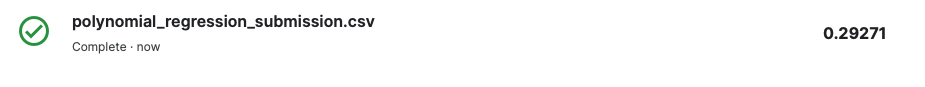

The polynomial regression of 'GrLivArea' produced worse results via Kaggle than when evaluating 'GrLivArea' with no transformations (using piecewise). In this case, the data better fit a linear model. This could be due to a few reasons such as overfitting (although we used k-cross validation) or non-linearity (this variable likely has a stronger non-linear relationship). 

# Regression model including: 'TotalSF' , 'OverallQual' , 'GarageCars' 

In [98]:
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']

X = train_df[['OverallQual', 'GarageCars', 'TotalSF']]
y = train_df['SalePrice']

model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Standard Deviation of RMSE: {np.std(rmse_scores)}')

model.fit(X, y)

test_df['TotalSF'] = test_df['TotalBsmtSF'] + test_df['1stFlrSF'] + test_df['2ndFlrSF']
test_X = test_df[['OverallQual', 'GarageCars', 'TotalSF']]

predictions = model.predict(test_X)

submission_df = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': predictions
})
submission_df.to_csv('multiple_predictors_submission.csv', index=False)


Average RMSE: 35413.004372074465
Standard Deviation of RMSE: 2280.9132418989066


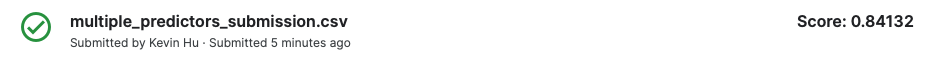

In [132]:
# Having problems with my 'TotalSF' dropping so remaking it here
train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']

X = train_df[['OverallQual', 'GarageCars', 'TotalSF']]
y = train_df['SalePrice']
X_train, X_pred, y_train, y_pred = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_pred)

# Training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
# Validation set
val_rmse = np.sqrt(mean_squared_error(y_pred, y_val_pred))
val_r2 = r2_score(y_pred, y_val_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Training R^2: {train_r2}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation R^2: {val_r2}")




Training RMSE: 35768.90766931695
Training R^2: 0.7960147006552012
Validation RMSE: 33052.359840058285
Validation R^2: 0.8318175194411119


Generally, from these values we can see that the model created holds similar values when used on the test data set. Although these values seem rather significant compared to other models with less variables.

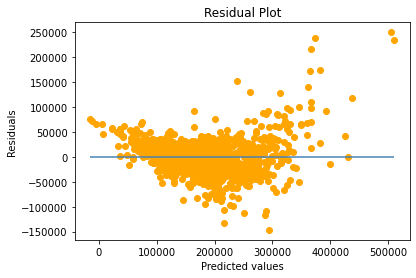

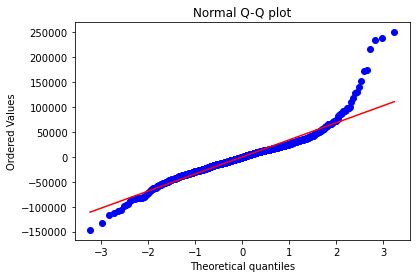

In [142]:
# Residual Analysis
residuals = y_train - y_train_pred
plt.scatter(y_train_pred, residuals, color='orange') 
plt.hlines(y=0, xmin=y_train_pred.min(), xmax=y_train_pred.max(), colors='steelblue')
plt.title("Residual Plot")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

# Normality of Residuals using Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt) 
plt.title("Normal Q-Q plot")
plt.show()


In [103]:
# Shapiro-Wilk test 
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test statistic: {shapiro_test[0]}")
print(f"Shapiro-Wilk test p-value: {shapiro_test[1]}")

Shapiro-Wilk test statistic: 0.9127282500267029
Shapiro-Wilk test p-value: 2.4780677435362963e-25


A p-value below 0.05 suggests the residuals are not normally distributed.